# lgbm-HyperOptu 데모

## 라이브러리 import 및 설정


In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import lightgbm as lgb
from pathlib import Path
from matplotlib import rcParams
import pandas as pd
import numpy as np
import warnings
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

rcParams['figure.figsize'] = (16, 8)       #그림 사이즈 지정
pd.set_option('max_columns', 100)          #칼럼 100개 허용
pd.set_option("display.precision", 4)      #소수점 4자리허용
warnings.simplefilter('ignore')            #경고분 무시

## 학습데이터 로드


In [21]:
feature_file = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv'
sample_file  = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\sample_submission.csv'
tst_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\test.csv'
trn_file     = 'C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\train.csv'

df= pd.read_csv(feature_file,index_col=0)        #학습/시험 데이터 
print(df.shape)                                  #(6113, 32)
df.head()                                        #위 5개            

(6113, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,188,128,95,114,143,108,88,103,113,85,88,113,87,88,103,87,84,99,104,82,96,100,78,70,79,84,66,70,75,76,63,HI
1,174,112,88,104,119,92,74,79,88,74,67,90,68,71,73,68,71,77,90,67,71,82,65,70,75,89,73,67,71,89,73,PH
2,175,138,106,105,135,109,75,95,113,96,74,112,96,70,87,100,66,83,117,67,88,110,98,67,88,119,98,75,91,110,94,GR
3,176,111,80,106,131,96,76,99,104,85,75,89,75,79,91,75,84,103,109,82,91,96,78,78,91,96,78,82,104,112,85,PH
4,182,144,111,100,151,119,67,106,114,90,76,115,94,68,106,91,68,102,115,71,95,108,88,71,103,113,92,68,107,118,92,EL


In [22]:
y = df.iloc[:,31].values[:4280]                  #학습_종속
df.drop(df.columns[[31]], axis=1, inplace=True)  #독립을 위한 종속 제거
trn = df.iloc[:4280].values                      #학습데이터_독립 4280개
tst = df.iloc[4280:].values                      #시험데이터_독립 1883개
print(y.shape, trn.shape, tst.shape)             #(4280,) (4280, 31) (1833, 31)

(4280,) (4280, 31) (1833, 31)


## 학습/검증 데이터 구분
학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리

#### [Hold-out Validation]

In [23]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

## Hyperparameter Tuning

In [24]:
params = {
    "objective": "multiclass",
    "n_estimators": 400,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1
}
#고정 파라미터

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "num_iterations":  hp.choice("num_iterations", [100, 200, 300, 400, 500, 600,800,1000]),
    "num_leaves": hp.choice("num_leaves", [16, 32, 64, 127, 254]),
    "min_child_samples": hp.choice("min_child_samples", [5, 10, 15, 20, 25, 30, 35,40,45,55]),
    "colsample_bytree": hp.quniform("colsample_bytree", .3, .9, 0.1),
    "subsample": hp.quniform("subsample", .3, .9, 0.1)
}
#변경 파라미터_넓은 범위와 여러 파라미터 사용시 시간 급증 (주의)

# loguniform: 로그함수를 이용해 확률 분포 내에서의 값으로 test
# choice: 리스트 값 중 하나로 선택하여 test
# quniform: start와 stop사이에서 일정 간격으로 값을 주어 test

In [25]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",#멀티클래스_로그 손실함수
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]
    #측정한 파라미터 중단됐을 때 최고의 성능점수

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials, algo=tpe.suggest, max_evals=10, verbose=1)
# fn=최소화하고 싶은 함수와 파라미터(space), 
# trials=실행 객체변수, tpe.sugges=알고리즘 선택
# max_evals=서치 횟수 

100%|███████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/trial, best loss: 0.22081227525353614]


In [26]:
hyperparams = space_eval(space, best)   #검색하여 나온 최적의 파라미터
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)                           #업데이트된 파라미터

{'objective': 'multiclass', 'n_estimators': 400, 'subsample_freq': 1, 'random_state': 150, 'n_jobs': -1, 'colsample_bytree': 0.5, 'learning_rate': 0.04503842176727723, 'min_child_samples': 35, 'num_iterations': 200, 'num_leaves': 16, 'subsample': 0.7000000000000001}


#1
{'objective': 'multiclass', 'subsample_freq': 1, 'random_state': 150, 'n_jobs': -1,   
'boosting_type': 'dart', 'colsample_bytree': 0.6000000000000001,   
'learning_rate': 0.028778270063003097, 'n_estimators': 100, 'num_iterations': 1000,  
'num_leaves': 31, 'subsample': 0.6000000000000001}
90.--

#2
{'objective': 'multiclass', 'subsample_freq': 1, 'random_state': 150,  
'n_jobs': -1, 'boosting_type': 'gbdt', 'colsample_bytree': 0.7000000000000001,   
'learning_rate': 0.06316437855450058, 'n_estimators': 600, 'num_leaves': 10,  
'subsample': 0.6000000000000001}  
91.308

#3 
{'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample_freq': 1,   
 'random_state': 150, 'n_jobs': -1, 'colsample_bytree': 0.7000000000000001,   
  'learning_rate': 0.0662586865182318, 'min_child_samples': 45, 'n_estimators': 200,    
 'num_iterations': 300, 'num_leaves': 31, 'subsample': 0.6000000000000001}

In [27]:
seed=150
n_fold =10

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [28]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

### [범주형 > 수치형 변환_종속변수]

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

label_str=y
label_int=le.fit_transform(label_str).astype('int')

## LightGBM 모델 학습

In [30]:
#93.3216% seed1022
p_val = np.zeros((trn.shape[0], 6))
p_tst = np.zeros((tst.shape[0], 6))
#(cv.split(),1)
# -  StratifiedKFold 경우, trn,y 독립과 종속(동일 분포를 위해) 인자
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    #확률로 예측값 초가화
    p_tst += clf.predict_proba(tst) / n_fold
    #평균 효과를 위해 먼저 폴드 개수만큼 나누어 초기화

training model for CV #1
[1]	valid_0's multi_logloss: 1.57706
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.45654
[3]	valid_0's multi_logloss: 1.35417
[4]	valid_0's multi_logloss: 1.26763
[5]	valid_0's multi_logloss: 1.18764
[6]	valid_0's multi_logloss: 1.11722
[7]	valid_0's multi_logloss: 1.05546
[8]	valid_0's multi_logloss: 1.00044
[9]	valid_0's multi_logloss: 0.947933
[10]	valid_0's multi_logloss: 0.900233
[11]	valid_0's multi_logloss: 0.8562
[12]	valid_0's multi_logloss: 0.8162
[13]	valid_0's multi_logloss: 0.779133
[14]	valid_0's multi_logloss: 0.745367
[15]	valid_0's multi_logloss: 0.714233
[16]	valid_0's multi_logloss: 0.685225
[17]	valid_0's multi_logloss: 0.65825
[18]	valid_0's multi_logloss: 0.633961
[19]	valid_0's multi_logloss: 0.611275
[20]	valid_0's multi_logloss: 0.589814
[21]	valid_0's multi_logloss: 0.570712
[22]	valid_0's multi_logloss: 0.552622
[23]	valid_0's multi_logloss: 0.534941
[24]	valid_0's multi_logloss: 0.519115


[95]	valid_0's multi_logloss: 0.330324
[96]	valid_0's multi_logloss: 0.329457
[97]	valid_0's multi_logloss: 0.329136
[98]	valid_0's multi_logloss: 0.327651
[99]	valid_0's multi_logloss: 0.326873
[100]	valid_0's multi_logloss: 0.326905
[101]	valid_0's multi_logloss: 0.325462
[102]	valid_0's multi_logloss: 0.324556
[103]	valid_0's multi_logloss: 0.325344
[104]	valid_0's multi_logloss: 0.32541
[105]	valid_0's multi_logloss: 0.325406
[106]	valid_0's multi_logloss: 0.32579
[107]	valid_0's multi_logloss: 0.326008
[108]	valid_0's multi_logloss: 0.325695
[109]	valid_0's multi_logloss: 0.32565
[110]	valid_0's multi_logloss: 0.325266
[111]	valid_0's multi_logloss: 0.324788
[112]	valid_0's multi_logloss: 0.324949
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.324556
training model for CV #3
[1]	valid_0's multi_logloss: 1.56889
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.4448
[3]	valid_0's multi_logloss: 1.33954
[4]	valid_0's mul

[45]	valid_0's multi_logloss: 0.344915
[46]	valid_0's multi_logloss: 0.340295
[47]	valid_0's multi_logloss: 0.336328
[48]	valid_0's multi_logloss: 0.332174
[49]	valid_0's multi_logloss: 0.327109
[50]	valid_0's multi_logloss: 0.322844
[51]	valid_0's multi_logloss: 0.320366
[52]	valid_0's multi_logloss: 0.315581
[53]	valid_0's multi_logloss: 0.311622
[54]	valid_0's multi_logloss: 0.309337
[55]	valid_0's multi_logloss: 0.307212
[56]	valid_0's multi_logloss: 0.304261
[57]	valid_0's multi_logloss: 0.301676
[58]	valid_0's multi_logloss: 0.299831
[59]	valid_0's multi_logloss: 0.296857
[60]	valid_0's multi_logloss: 0.294337
[61]	valid_0's multi_logloss: 0.292249
[62]	valid_0's multi_logloss: 0.290236
[63]	valid_0's multi_logloss: 0.286843
[64]	valid_0's multi_logloss: 0.284769
[65]	valid_0's multi_logloss: 0.283194
[66]	valid_0's multi_logloss: 0.282395
[67]	valid_0's multi_logloss: 0.280934
[68]	valid_0's multi_logloss: 0.278108
[69]	valid_0's multi_logloss: 0.276716
[70]	valid_0's multi_logl

[124]	valid_0's multi_logloss: 0.24673
[125]	valid_0's multi_logloss: 0.246161
[126]	valid_0's multi_logloss: 0.246452
[127]	valid_0's multi_logloss: 0.246485
[128]	valid_0's multi_logloss: 0.245674
[129]	valid_0's multi_logloss: 0.245162
[130]	valid_0's multi_logloss: 0.244472
[131]	valid_0's multi_logloss: 0.244247
[132]	valid_0's multi_logloss: 0.244069
[133]	valid_0's multi_logloss: 0.242941
[134]	valid_0's multi_logloss: 0.242566
[135]	valid_0's multi_logloss: 0.242528
[136]	valid_0's multi_logloss: 0.24217
[137]	valid_0's multi_logloss: 0.242392
[138]	valid_0's multi_logloss: 0.241697
[139]	valid_0's multi_logloss: 0.240828
[140]	valid_0's multi_logloss: 0.240806
[141]	valid_0's multi_logloss: 0.240915
[142]	valid_0's multi_logloss: 0.240575
[143]	valid_0's multi_logloss: 0.240698
[144]	valid_0's multi_logloss: 0.239715
[145]	valid_0's multi_logloss: 0.238989
[146]	valid_0's multi_logloss: 0.238705
[147]	valid_0's multi_logloss: 0.23879
[148]	valid_0's multi_logloss: 0.238501
[14

[187]	valid_0's multi_logloss: 0.190615
[188]	valid_0's multi_logloss: 0.190384
[189]	valid_0's multi_logloss: 0.190465
[190]	valid_0's multi_logloss: 0.190913
[191]	valid_0's multi_logloss: 0.191009
[192]	valid_0's multi_logloss: 0.191534
[193]	valid_0's multi_logloss: 0.191633
[194]	valid_0's multi_logloss: 0.191772
Early stopping, best iteration is:
[184]	valid_0's multi_logloss: 0.189571
training model for CV #7
[1]	valid_0's multi_logloss: 1.5652
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.43636
[3]	valid_0's multi_logloss: 1.325
[4]	valid_0's multi_logloss: 1.23255
[5]	valid_0's multi_logloss: 1.14913
[6]	valid_0's multi_logloss: 1.07679
[7]	valid_0's multi_logloss: 1.01248
[8]	valid_0's multi_logloss: 0.953285
[9]	valid_0's multi_logloss: 0.89896
[10]	valid_0's multi_logloss: 0.849589
[11]	valid_0's multi_logloss: 0.80554
[12]	valid_0's multi_logloss: 0.765223
[13]	valid_0's multi_logloss: 0.727888
[14]	valid_0's multi_logloss: 0.6

[67]	valid_0's multi_logloss: 0.248849
[68]	valid_0's multi_logloss: 0.248616
[69]	valid_0's multi_logloss: 0.247657
[70]	valid_0's multi_logloss: 0.246509
[71]	valid_0's multi_logloss: 0.245529
[72]	valid_0's multi_logloss: 0.243544
[73]	valid_0's multi_logloss: 0.242712
[74]	valid_0's multi_logloss: 0.241239
[75]	valid_0's multi_logloss: 0.240244
[76]	valid_0's multi_logloss: 0.238932
[77]	valid_0's multi_logloss: 0.238067
[78]	valid_0's multi_logloss: 0.23771
[79]	valid_0's multi_logloss: 0.237637
[80]	valid_0's multi_logloss: 0.237072
[81]	valid_0's multi_logloss: 0.23625
[82]	valid_0's multi_logloss: 0.235221
[83]	valid_0's multi_logloss: 0.234568
[84]	valid_0's multi_logloss: 0.233763
[85]	valid_0's multi_logloss: 0.234077
[86]	valid_0's multi_logloss: 0.233509
[87]	valid_0's multi_logloss: 0.232401
[88]	valid_0's multi_logloss: 0.231491
[89]	valid_0's multi_logloss: 0.231094
[90]	valid_0's multi_logloss: 0.230521
[91]	valid_0's multi_logloss: 0.230232
[92]	valid_0's multi_loglos

[151]	valid_0's multi_logloss: 0.217345
[152]	valid_0's multi_logloss: 0.217549
[153]	valid_0's multi_logloss: 0.21795
[154]	valid_0's multi_logloss: 0.218303
[155]	valid_0's multi_logloss: 0.217669
[156]	valid_0's multi_logloss: 0.218588
[157]	valid_0's multi_logloss: 0.219046
[158]	valid_0's multi_logloss: 0.21877
[159]	valid_0's multi_logloss: 0.218666
[160]	valid_0's multi_logloss: 0.219021
[161]	valid_0's multi_logloss: 0.219765
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.217345
training model for CV #10
[1]	valid_0's multi_logloss: 1.57746
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.45503
[3]	valid_0's multi_logloss: 1.35037
[4]	valid_0's multi_logloss: 1.26481
[5]	valid_0's multi_logloss: 1.18345
[6]	valid_0's multi_logloss: 1.11464
[7]	valid_0's multi_logloss: 1.05387
[8]	valid_0's multi_logloss: 0.998207
[9]	valid_0's multi_logloss: 0.94972
[10]	valid_0's multi_logloss: 0.905817
[11]	valid_0's multi_loglos

** ( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() ) **

In [31]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

0.0000%


## 피처 중요도 시각화
여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

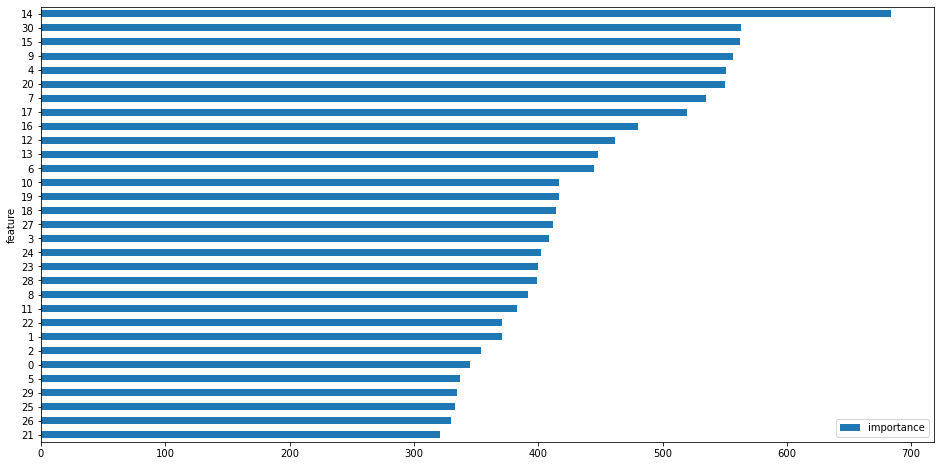

In [32]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### [수치형 > 범주형 변환_종속변수]

In [33]:
pt=np.zeros(shape=(1833,))
pt = pt.astype(np.int64)
for x in range(0,1833):
    pt[x] = np.argmax(p_tst[x,:])
target=le.inverse_transform(pt)
target

array(['HI', 'EL', 'HI', ..., 'PH', 'PH', 'HI'], dtype=object)

## 제출 파일 생성

In [ ]:
#sub = pd.read_csv(sample_file)
#sub['class']
sub = pd.read_csv(sample_file)
sub['class'] = p_tst
sub.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\sub\\lgbmHyper-sub.csv',index=False,header=False)